<a href="https://colab.research.google.com/github/mykon23/AI-2020/blob/master/Activities/Activity14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Fine Tuning Hyper-Parameters: MLB Playoff Teams

In [1]:
!wget -O Baseball.csv https://github.com/mykon23/AI-2020/blob/master/Data/Baseball.csv?raw=True

--2020-10-22 00:47:17--  https://github.com/mykon23/AI-2020/blob/master/Data/Baseball.csv?raw=True
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mykon23/AI-2020/raw/master/Data/Baseball.csv [following]
--2020-10-22 00:47:18--  https://github.com/mykon23/AI-2020/raw/master/Data/Baseball.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mykon23/AI-2020/master/Data/Baseball.csv [following]
--2020-10-22 00:47:18--  https://raw.githubusercontent.com/mykon23/AI-2020/master/Data/Baseball.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 20

##Binary Classification of whether an MLB Team Enters Playoffs (WildCard Era)

In [2]:
import pandas as pd
data = pd.read_csv('Baseball.csv')
data.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


In [3]:
##Get the features of interest
features = [ 'RS', 'RA', 'W', 'OBP', 'SLG', 'BA' ]

##Binary classiciation to determine if playoff team
output = [ 'Playoffs' ]

##Only get data from wildcard era introduced in 1994.  8+ teams enter
work_data = data[ data['Year'] > 1994 ]
work_data = work_data[ ['Year'] + features + output ]
work_data.head()

,Year,RS,RA,W,OBP,SLG,BA,Playoffs
0,2012,734,688,81,0.328,0.418,0.259,0
1,2012,700,600,94,0.320,0.389,0.247,1
2,2012,712,705,93,0.311,0.417,0.247,1
3,2012,734,806,69,0.315,0.415,0.260,0
4,2012,613,759,61,0.302,0.378,0.240,0


Split the Data into Training Set and Validation Set

In [4]:
import numpy as np

##Validation set will be split according to random years.  No shuffling of data.
years = work_data['Year'].unique()
val_years = np.random.choice( years, int(0.25 * len(years)), replace=False )
print(val_years)

[2004 2011 1997 2009]


In [5]:
TRAIN = pd.DataFrame()
VALID = pd.DataFrame()

for y in years:
  elem = work_data[ work_data['Year'] == y ][ features + output ]
  if y in val_years:
    VALID = pd.concat( [VALID, elem] )
  else:
    TRAIN = pd.concat( [TRAIN, elem] )

##Training Set
TRAIN = TRAIN.to_numpy()
XTRAIN = TRAIN[:, :-1]
YTRAIN = TRAIN[:, -1]

##Valdiation Set
VALID = VALID.to_numpy()
XVALID = VALID[:, :-1]
YVALID = VALID[:, -1]

In [6]:
##Get Baseline Accuracy
baseline = pd.DataFrame.from_dict({ 'train': [YTRAIN.sum()/len(YTRAIN)],
                                   'valid': [YVALID.sum()/len(YVALID)]})
baseline.head()

,train,valid
0,0.273196,0.271186


Normalize Data

In [7]:
##Adjust the training data
mean = XTRAIN.mean(axis = 0)
XTRAIN -= mean
std = XTRAIN.std(axis = 0)
XTRAIN /= std

##Adjust the validation data
XVALID -= mean
XVALID /= std

##Evaluation Utilities

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

DEFAULT_EPOCHS = 200
DEFAULT_BATCH = 32

class PlotUtil:
  @staticmethod
  def get_learning_curve(history):
    metrics = ['loss', 'accuracy']
    f, ax = plt.subplots(1,2, figsize=(12,4))
    f.tight_layout = True
    for i in range(len(metrics)):
      ax[i].plot(history.history[metrics[i]], '-', label = 'Training', color = 'blue')
      ax[i].plot(history.history['val_' + metrics[i]], '--', label = 'Validation', color = 'orange')
      ax[i].set_ylabel(metrics[i])
      ax[i].set_xlabel('epoch')
      ax[i].legend()
    return (f, ax)

class MetricsUtil:
  @staticmethod
  def get_metrics(y_true, y_pred):
    return { 'accuracy': accuracy_score(y_true, y_pred.round()),
            'precision': precision_score(y_true, y_pred.round()),
            'recall': recall_score(y_true, y_pred.round()) }

##Effects of Layers

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(2, input_dim = len(features), activation = 'relu' ))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)


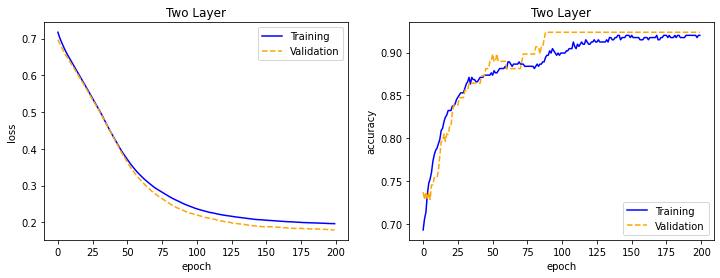

In [11]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Two Layer')
fig[0].show()

In [12]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.922680,0.923729
precision,0.865385,0.848485
recall,0.849057,0.875000


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)

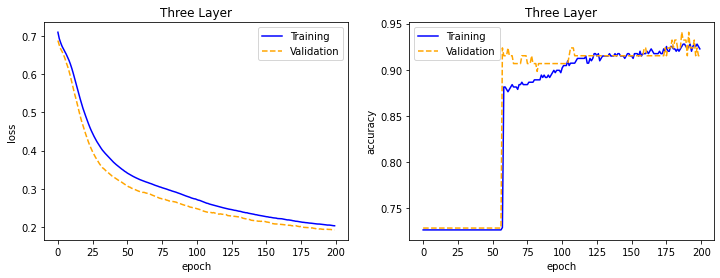

In [14]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Three Layer')
fig[0].show()

In [15]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.925258,0.915254
precision,0.853211,0.823529
recall,0.877358,0.875000


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)

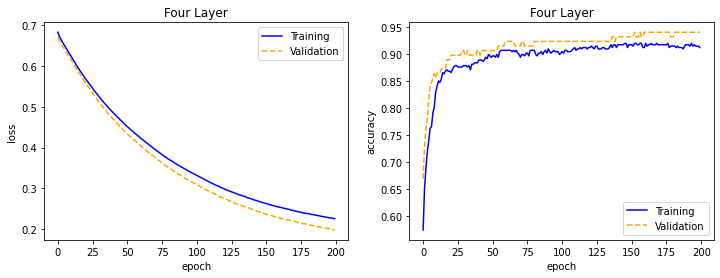

In [17]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Four Layer')
fig[0].show()

In [18]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.917526,0.940678
precision,0.885417,0.878788
recall,0.801887,0.906250


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(12, input_dim = len(features), activation = 'relu' ))
model.add( Dense(6, activation = 'relu'))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)

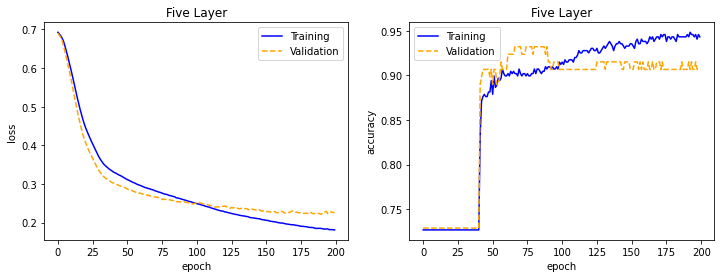

In [20]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Five Layer')
fig[0].show()

In [21]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.945876,0.906780
precision,0.889908,0.818182
recall,0.915094,0.843750


The four layer model yields the greatest accuracy.  The models were constructed with variable depth and initialized with variable neurons per layer.  The deeper models tend to overfit the data as depicted in the five layer model.

##Effects of Neurons Per Layer

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(4, input_dim = len(features), activation = 'relu' ))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)

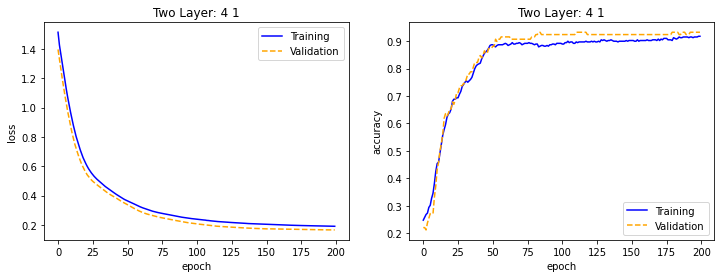

In [27]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Two Layer: 4 1')
fig[0].show()

In [28]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.917526,0.932203
precision,0.862745,0.875000
recall,0.830189,0.875000


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(8, input_dim = len(features), activation = 'relu' ))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)

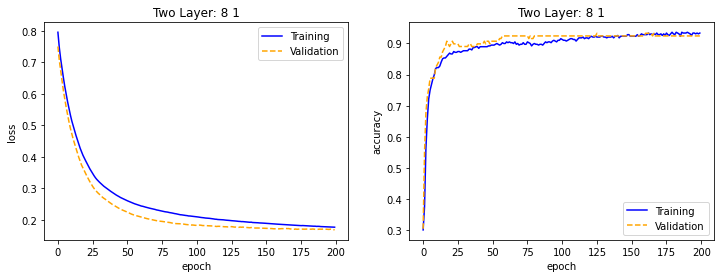

In [30]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Two Layer: 8 1')
fig[0].show()

In [31]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.935567,0.923729
precision,0.900990,0.848485
recall,0.858491,0.875000


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)

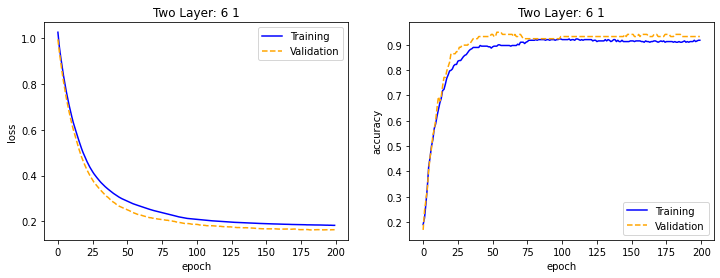

In [33]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Two Layer: 6 1')
fig[0].show()

In [34]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.912371,0.932203
precision,0.833333,0.875000
recall,0.849057,0.875000


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(4, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)

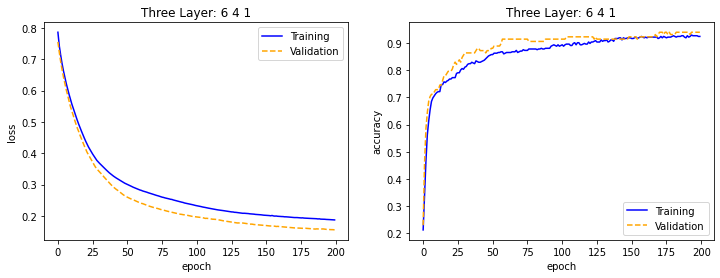

In [36]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Three Layer: 6 4 1')
fig[0].show()

In [37]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.932990,0.940678
precision,0.877358,0.878788
recall,0.877358,0.906250


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(8, input_dim = len(features), activation = 'relu' ))
model.add( Dense(4, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)

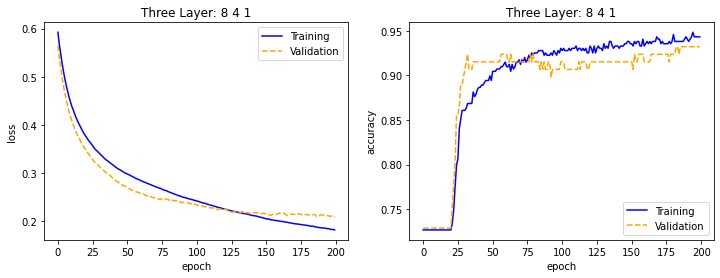

In [39]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Three Layer: 8 4 1')
fig[0].show()

In [40]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.945876,0.932203
precision,0.904762,0.852941
recall,0.896226,0.906250


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(12, input_dim = len(features), activation = 'relu' ))
model.add( Dense(8, activation = 'relu'))
model.add( Dense(4, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)

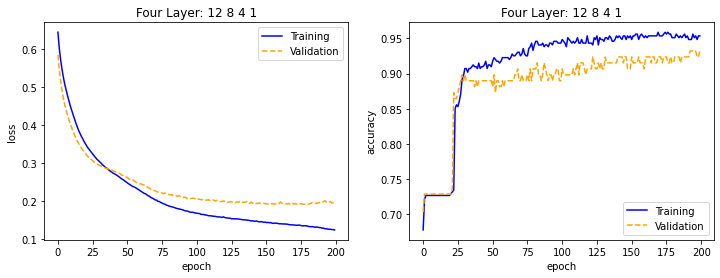

In [42]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Four Layer: 12 8 4 1')
fig[0].show()

In [43]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.956186,0.932203
precision,0.915888,0.852941
recall,0.924528,0.906250


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(16, input_dim = len(features), activation = 'relu' ))
model.add( Dense(8, activation = 'relu'))
model.add( Dense(4, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)

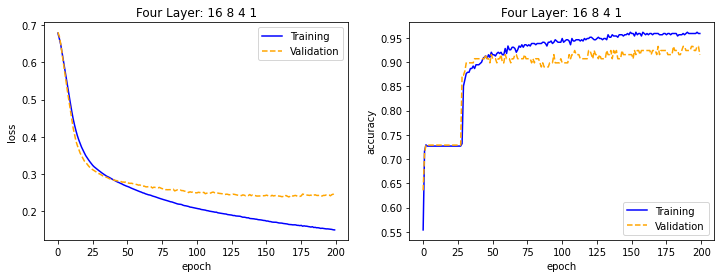

In [45]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Four Layer: 16 8 4 1')
fig[0].show()

In [46]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.96134,0.915254
precision,0.90991,0.843750
recall,0.95283,0.843750


The two layer, three layer, and four layer models from the layers experiment were adjusted to contain updated neurons.  Increasing the neurons for the two layer model increased the accuracy to be on par with those of the three and four layer models.  The accuracy of the three and four layer model decayed as more neurons were added yielding overfitting as the training loss and validation loss diverged.

##Effects of Batch Sizes

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH//4,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)

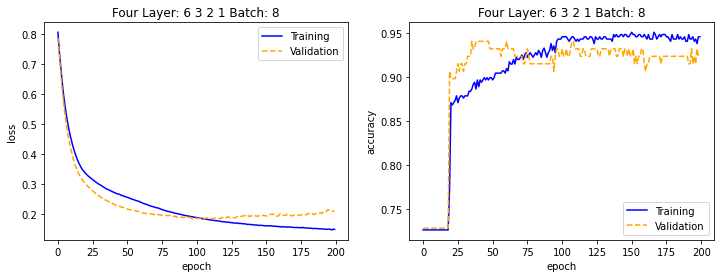

In [61]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Four Layer: 6 3 2 1 Batch: 8')
fig[0].show()

In [62]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.945876,0.923729
precision,0.897196,0.828571
recall,0.905660,0.906250


In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH//2,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)

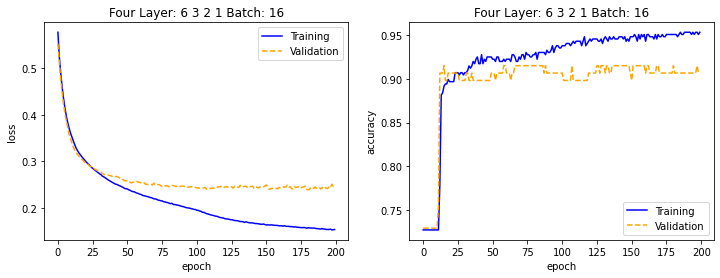

In [64]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Four Layer: 6 3 2 1 Batch: 16')
fig[0].show()

In [65]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.953608,0.906780
precision,0.900000,0.818182
recall,0.933962,0.843750


In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH * 2,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)

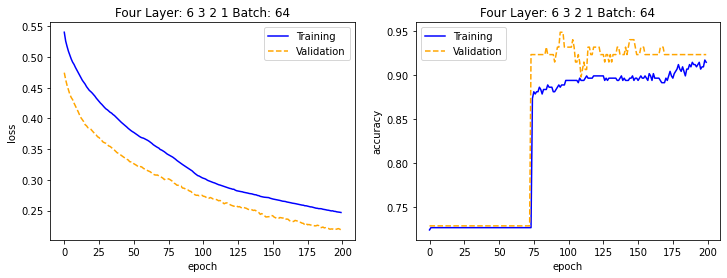

In [67]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Four Layer: 6 3 2 1 Batch: 64')
fig[0].show()

In [68]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.914948,0.923729
precision,0.841121,0.848485
recall,0.849057,0.875000


In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH * 4,
                    epochs = DEFAULT_EPOCHS,
                    verbose = 0)

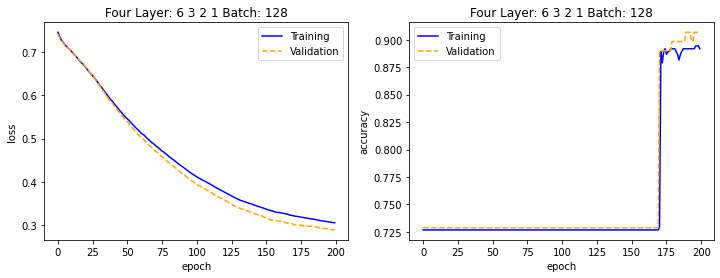

In [70]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Four Layer: 6 3 2 1 Batch: 128')
fig[0].show()

In [71]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.891753,0.90678
precision,0.840426,0.83871
recall,0.745283,0.81250


Variable batch sizes were applied to the four layer model and it was observed that divergence occurs in the model if the batch size is too small.  The model benefits from an increased batch size than the default as it prevents overfitting.  The smaller batch sizes behave similarly to an overfitting model as the training loss decays early in the training.

##Effects of Epochs

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH * 2,
                    epochs = DEFAULT_EPOCHS * 2,
                    verbose = 0)

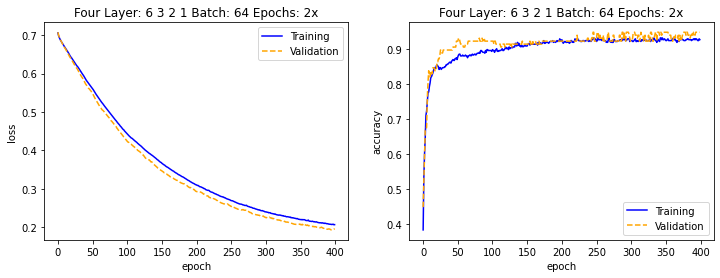

In [73]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Four Layer: 6 3 2 1 Batch: 64 Epochs: 2x')
fig[0].show()

In [74]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.927835,0.949153
precision,0.897959,0.933333
recall,0.830189,0.875000


In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH * 2,
                    epochs = DEFAULT_EPOCHS * 3,
                    verbose = 0)

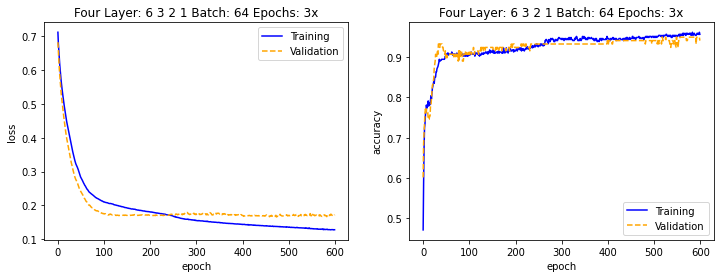

In [82]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Four Layer: 6 3 2 1 Batch: 64 Epochs: 3x')
fig[0].show()

In [83]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.958763,0.940678
precision,0.916667,0.878788
recall,0.933962,0.906250


In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH * 4,
                    epochs = DEFAULT_EPOCHS * 2,
                    verbose = 0)

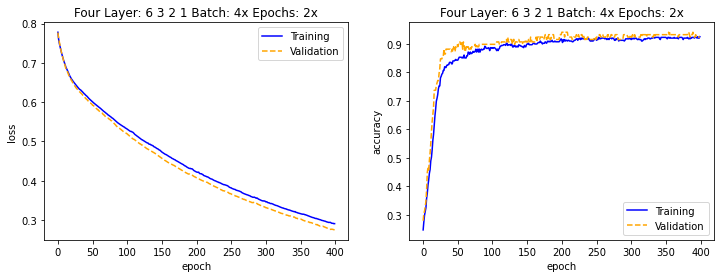

In [79]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Four Layer: 6 3 2 1 Batch: 4x Epochs: 2x')
fig[0].show()

In [80]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.925258,0.923729
precision,0.853211,0.848485
recall,0.877358,0.875000


In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH * 4,
                    epochs = DEFAULT_EPOCHS * 4,
                    verbose = 0)

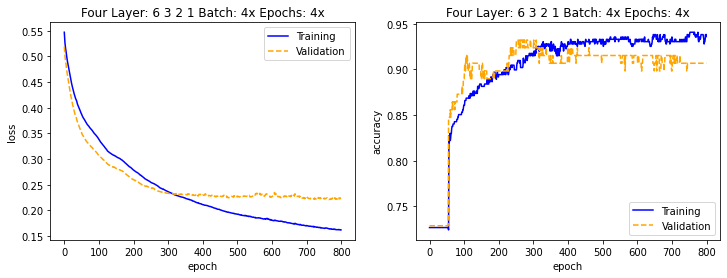

In [85]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Four Layer: 6 3 2 1 Batch: 4x Epochs: 4x')
fig[0].show()

In [86]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.930412,0.90678
precision,0.837607,0.80000
recall,0.924528,0.87500


The four layer model with an augmented batch size benefits from additional epochs.  The four layer model yields the strongest accuracy is the one trained with a batch size of 64 and trained for 400 epochs.  The additional epochs compensate for the slower decrease in the training loss that occurs with the increased batch size.

##Effects of Optimizers

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='sgd', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH * 2,
                    epochs = DEFAULT_EPOCHS * 2,
                    verbose = 0)

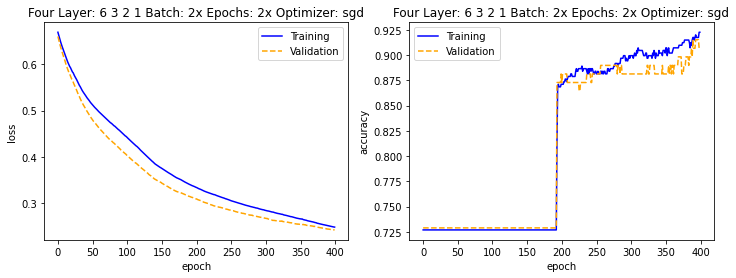

In [88]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Four Layer: 6 3 2 1 Batch: 2x Epochs: 2x Optimizer: sgd')
fig[0].show()

In [89]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.922680,0.90678
precision,0.858491,0.83871
recall,0.858491,0.81250


In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='sgd', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH * 2,
                    epochs = DEFAULT_EPOCHS * 3,
                    verbose = 0)

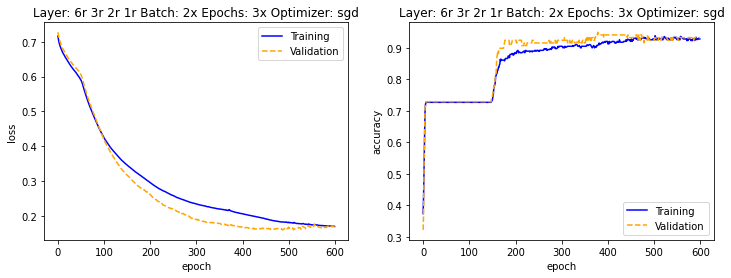

In [123]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Layer: 6r 3r 2r 1r Batch: 2x Epochs: 3x Optimizer: sgd')
fig[0].show()

In [124]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.927835,0.932203
precision,0.861111,0.875000
recall,0.877358,0.875000


In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='nadam', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH * 2,
                    epochs = DEFAULT_EPOCHS * 2,
                    verbose = 0)

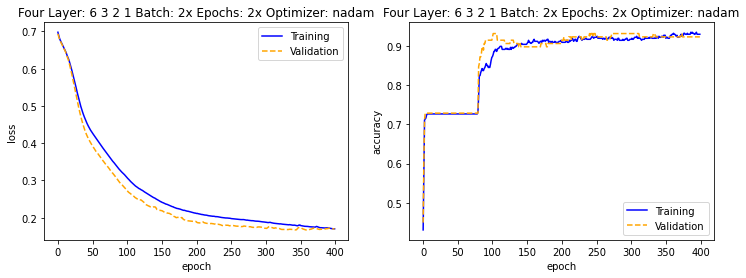

In [91]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Four Layer: 6 3 2 1 Batch: 2x Epochs: 2x Optimizer: nadam')
fig[0].show()

In [92]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.930412,0.923729
precision,0.862385,0.848485
recall,0.886792,0.875000


In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH * 2,
                    epochs = DEFAULT_EPOCHS * 2,
                    verbose = 0)

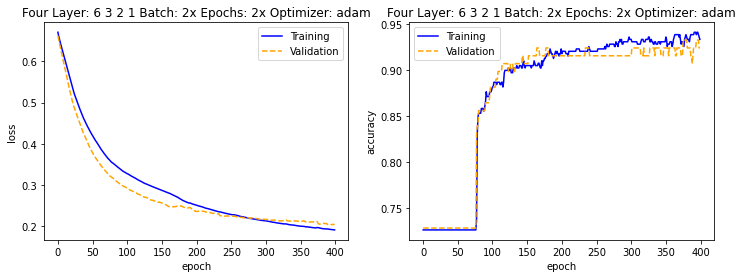

In [94]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Four Layer: 6 3 2 1 Batch: 2x Epochs: 2x Optimizer: adam')
fig[0].show()

In [95]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.932990,0.923729
precision,0.863636,0.870968
recall,0.896226,0.843750


The four layer model was adjusted to observe the effects of the optimizers.  The model was copiled with the rmsprop, sgd, nadam and adam optimzers.  The rmsprop optimizer yields the strongest performance on the validation set.  The sgd optimizer appeared promising and was trained through an additional 200 epochs, but did not reach the performance of rmsprop.

##Effects of Activation Functions

In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'relu'))
model.add( Dense(2, activation = 'relu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH * 2,
                    epochs = DEFAULT_EPOCHS * 2,
                    verbose = 0)

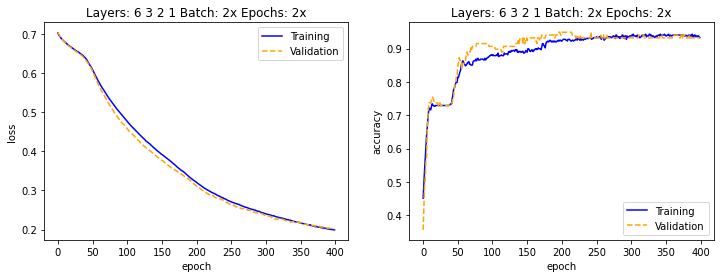

In [104]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Layers: 6 3 2 1 Batch: 2x Epochs: 2x')
fig[0].show()

In [105]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.938144,0.932203
precision,0.901961,0.875000
recall,0.867925,0.875000


In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'elu' ))
model.add( Dense(3, activation = 'elu'))
model.add( Dense(2, activation = 'elu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH * 2,
                    epochs = DEFAULT_EPOCHS * 2,
                    verbose = 0)

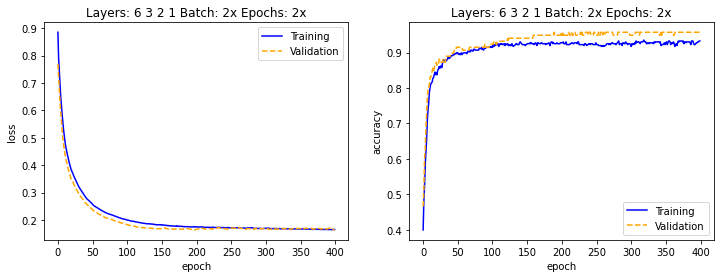

In [115]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Layers: 6 3 2 1 Batch: 2x Epochs: 2x')
fig[0].show()

In [114]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.932990,0.957627
precision,0.900000,0.935484
recall,0.849057,0.906250


In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'elu' ))
model.add( Dense(3, activation = 'elu'))
model.add( Dense(2, activation = 'sigmoid'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH * 2,
                    epochs = DEFAULT_EPOCHS * 2,
                    verbose = 0)

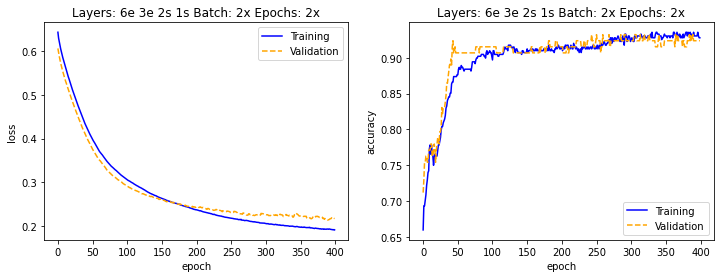

In [117]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Layers: 6e 3e 2s 1s Batch: 2x Epochs: 2x')
fig[0].show()

In [118]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.932990,0.923729
precision,0.877358,0.828571
recall,0.877358,0.906250


In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(6, input_dim = len(features), activation = 'relu' ))
model.add( Dense(3, activation = 'elu'))
model.add( Dense(2, activation = 'elu'))
model.add( Dense(1, activation = 'sigmoid' ))

model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

history = model.fit( XTRAIN, YTRAIN,
                    validation_data = (XVALID, YVALID),
                    batch_size = DEFAULT_BATCH * 2,
                    epochs = DEFAULT_EPOCHS * 2,
                    verbose = 0)

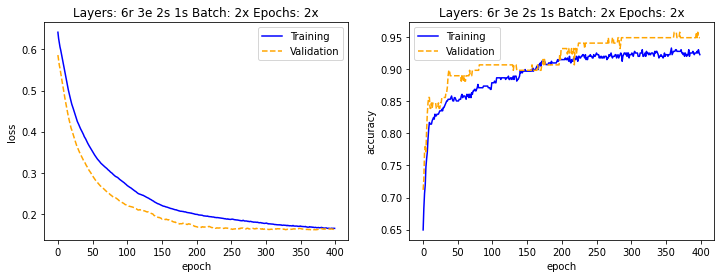

In [120]:
##View the Learning Curves
fig = PlotUtil.get_learning_curve(history)
for f in fig[1]:
  f.set_title('Layers: 6r 3e 2s 1s Batch: 2x Epochs: 2x')
fig[0].show()

In [121]:
##Get the Predictions on Training and Validation
train_pred = model.predict(XTRAIN)
valid_pred = model.predict(XVALID)

pd.DataFrame.from_dict({ 'train': MetricsUtil.get_metrics(YTRAIN, train_pred),
                        'valid': MetricsUtil.get_metrics(YVALID, valid_pred)}).head()

,train,valid
accuracy,0.927835,0.949153
precision,0.890000,0.906250
recall,0.839623,0.906250


The four layer model was augmented to have variable activation functios prior to the final layer.  A model with the final two layers set to sigmoid does not yield a model with better performance than a single sigmoid.  The model benefits from the introduction of the elu activation function as these result in a greater accuracy.  The strongest accuracy was observed in a model where all the layers preceding the sigmoid were set to elu.